# Composable Classes for Heterogeneous SEIR Modeling

This notebook provides a basic setup for heterogeneous SEIR modeling. The example uses two populations with very different behaviors that interact on occasion, named "sheep" and "goats". The sheep behave in a safe manner, while goats behave in an unsafe manner. The interactions between sheep and goats show that goats can significantly prolong the epidemic even if they interact very infrequently with sheep. The sheep mitigate the viral spread in goats, while goats significantly increase viral spread in sheep.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, linalg
from enum import Enum
from typing import Mapping

In [15]:
class PopulationSpec:
    
    def __init__(self, name, population, s, e, i, r, i_rate, r_rate, s_rate=0.0):
        """Specs out a population's SEIR properties.
        
        Starting S, E, I, R, and population are provided, as well as
        the population's rate from exposed to infected, and infected to recovered.
        """
        self._name = name
        self._s = s
        self._e = e
        self._i = i
        self._r = r
        self._population = s + e + i + r
        self._i_rate = i_rate
        self._r_rate = r_rate
        self._s_rate = s_rate
        
    def y0(self):
        return [self._s, self._e, self._i, self._r]
    
    def params(self):
        return [self._name + ': ' + x for x in ['s', 'e', 'i', 'r']]
        
    def population(self):
        return self._population
    
    def transition_matrix(self):
        return np.array([[0., 0., 0., self._s_rate],
                         [0., -self._i_rate, 0., 0.],
                         [0., self._i_rate, -self._r_rate, 0.],
                         [0., 0., self._r_rate, -self._s_rate],
                        ])
    
        
class InteractionSpec:
    
    def __init__(self, from_pop, to_pop, x_rate_fn):
        """Rate of transmission between two populations.
        
        Populations can be the same population for internal transmission rates.
        """
        self._from_pop = from_pop
        self._to_pop = to_pop
        if callable(x_rate_fn):
            self._x_rate_fn = x_rate_fn
        else:
            self._x_rate_fn = (lambda x: x_rate_fn)
        

class PopulationCollection:
    def __init__(self):
        self.populations = {}
        
    

In [16]:
def simulate(pop_specs, xact_specs, days):
    y0 = np.zeros(0)
    A = np.zeros((0, 0))

    y0 = np.concatenate([pop_spec.y0() for pop_spec in pop_specs])
    A = linalg.block_diag(*[pop_spec.transition_matrix() for pop_spec in pop_specs])
    total_pop = sum([pop_spec.population() for pop_spec in pop_specs])

    pop_specs_indexed = dict([(y, x) for x, y in enumerate(pop_specs)])    

    t_init = 0.

    def ode_fn(t, y):
        A_complete = np.copy(A)
        for xact_spec in xact_specs:
            from_index = pop_specs_indexed[xact_spec._from_pop] * 4 + 2
            to_index = pop_specs_indexed[xact_spec._to_pop] * 4
            A_complete[to_index, to_index] -= y[from_index] * xact_spec._x_rate_fn(t) / xact_spec._to_pop.population()
            A_complete[to_index + 1, to_index] += y[from_index] * xact_spec._x_rate_fn(t) / xact_spec._to_pop.population()
        return A_complete.dot(y)

    results = integrate.RK45(ode_fn, t_init, y0, days)

    t_seq = np.arange(0.1, days, 0.1)
    y_all = []
    results.step()
    dense_output = results.dense_output()
    for t in t_seq:
        while t > dense_output.t_max:
            results.step()
            dense_output = results.dense_output()
        y_all.append(dense_output(t))


    labels = [pop.params() for pop in pop_specs]
    labels = [item for sublist in labels for item in sublist]
    return t_seq, labels, np.array(y_all)




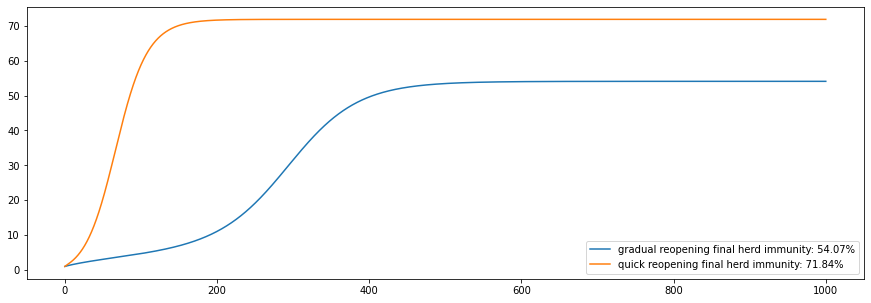

In [60]:
# Single population spec
STARTING_INFECTIONS = 1
TOTAL_POPULATION = 100
I_RATE = 1 / 3.6
R_RATE = 1 / 10.
S_RATE = 0.0
E_RATE = 1 / 10 * 1.75 # R = 1.75
E_RATE_MIN = 1 / 10 * 0.8 # R0 during lockdown.
REOPEN_RATE = 1 / 180 # One reopening phase per 14 days
DAYS = 1000

def e_rate_reopen_fn(t):
    """A sigmoid that starts at a fraction of E_RATE and maxes out at E_RATE"""
    return (E_RATE - E_RATE_MIN) * (1 - np.exp(-REOPEN_RATE * t) - (E_RATE - E_RATE_MIN)) + E_RATE_MIN
    #return np.minimum(E_RATE, (E_RATE - E_RATE_MIN) * REOPEN_RATE * t + E_RATE_MIN)

def e_rate_normal_fn(t):
    return E_RATE

# Create populations and interactions
pop_spec = PopulationSpec('total', TOTAL_POPULATION,
                          TOTAL_POPULATION - STARTING_INFECTIONS, 0, STARTING_INFECTIONS, 0,
                          I_RATE, R_RATE, S_RATE)
xact_spec_reopen = InteractionSpec(pop_spec, pop_spec, e_rate_reopen_fn)
xact_spec_normal = InteractionSpec(pop_spec, pop_spec, e_rate_normal_fn)

plt.figure(figsize=(15, 5))

t_seq, labels, y_reopen = simulate([pop_spec], [xact_spec_reopen], DAYS)
t_seq, labels, y_normal = simulate([pop_spec], [xact_spec_normal], DAYS)

plt.plot(t_seq, np.sum(y_reopen[:,1:4], axis=-1), label='gradual reopening final herd immunity: {:.2f}%'.format(
    np.sum(y_reopen[-1,1:4]) / TOTAL_POPULATION * 100,
))
plt.plot(t_seq, np.sum(y_normal[:,1:4], axis=-1), label='quick reopening final herd immunity: {:.2f}%'.format(
    np.sum(y_normal[-1,1:4]) / TOTAL_POPULATION * 100,
))
plt.legend()
plt.show()

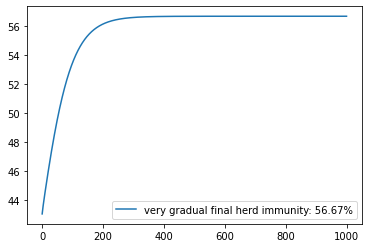

In [58]:
# Suppose you let people get infected at 4% every 10 days, creating a 100 day reopening plan.
pop_mid_spec = PopulationSpec('mid', TOTAL_POPULATION,
                              TOTAL_POPULATION - 0.43 * TOTAL_POPULATION,
                              0,
                              0.02 * TOTAL_POPULATION,
                              0.41 * TOTAL_POPULATION,
                              I_RATE, R_RATE, S_RATE)

xact_mid_spec = InteractionSpec(pop_mid_spec, pop_mid_spec, e_rate_normal_fn)

t_seq, labels, y_mid = simulate([pop_mid_spec], [xact_mid_spec], DAYS)

plt.plot(t_seq, np.sum(y_mid[:,1:4], axis=-1), label='very gradual final herd immunity: {:.2f}%'.format(
    np.sum(y_mid[-1,1:4]) / TOTAL_POPULATION * 100,
))
plt.legend()
plt.show()

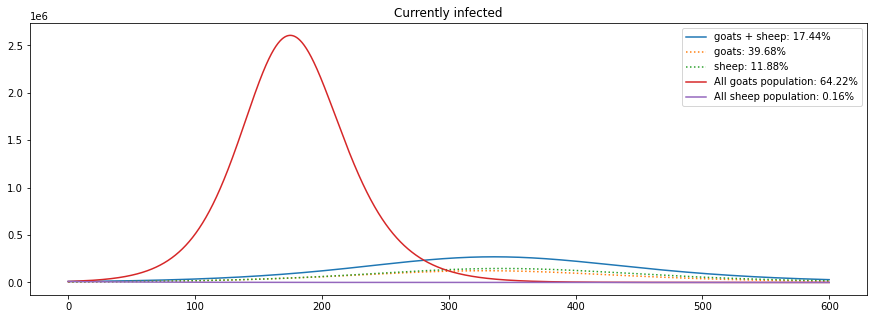

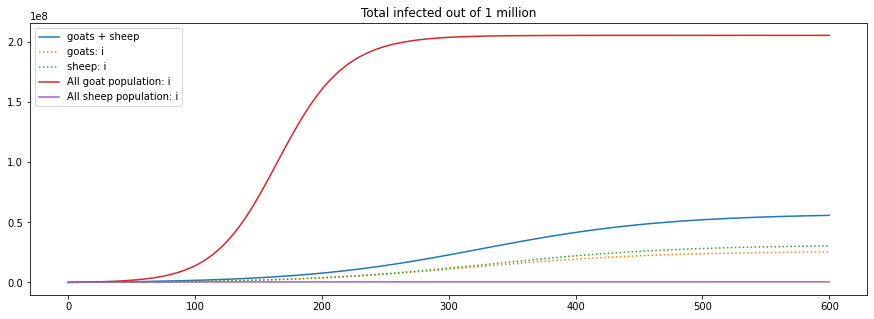

(5999, 4)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [46]:
# Create specs
STARTING_INFECTIONS = 100000
TOTAL_POPULATION = 320000000
GOAT_POPULATION = 64000000
I_RATE = 1 / 3.6
R_RATE = 1 / 10.
S_RATE = 0.0
E_RATE_FAST = 1 / 10 * 1.6 # R = 1.6
E_RATE_SLOW = 1 / 10 * 0.8 # R = 0.8
FAST_SLOW_CROSS_PROB = 0.5
SLOW_FAST_CROSS_PROB = 0.5
DAYS = 600

# Create populations and interactions
pop_spec1 = PopulationSpec('goats', GOAT_POPULATION,
                           GOAT_POPULATION - STARTING_INFECTIONS / 3, 0, STARTING_INFECTIONS / 3, 0,
                           I_RATE, R_RATE, S_RATE)
pop_spec2 = PopulationSpec('sheep', TOTAL_POPULATION - GOAT_POPULATION,
                           TOTAL_POPULATION - GOAT_POPULATION - STARTING_INFECTIONS / 3 * 2, 0, STARTING_INFECTIONS / 3 * 2, 0,
                           I_RATE, R_RATE, S_RATE)
pop_specs = [pop_spec1, pop_spec2]

xact_specs = []
xact_specs.append(InteractionSpec(pop_spec1, pop_spec1, E_RATE_FAST * (1 - FAST_SLOW_CROSS_PROB)))
xact_specs.append(InteractionSpec(pop_spec1, pop_spec2, E_RATE_FAST * FAST_SLOW_CROSS_PROB))
xact_specs.append(InteractionSpec(pop_spec2, pop_spec2, E_RATE_SLOW * (1 - SLOW_FAST_CROSS_PROB)))
xact_specs.append(InteractionSpec(pop_spec2, pop_spec1, E_RATE_SLOW * SLOW_FAST_CROSS_PROB))

plt.figure(figsize=(15, 5))

t_seq, labels, y_all = simulate(pop_specs, xact_specs, DAYS)
mixed_total = np.sum(y_all[:,1::4] + y_all[:,2::4] + y_all[:,3::4], axis=-1)
goat_total = np.sum(y_all[:,1:4], axis=-1)
sheep_total = np.sum(y_all[:,5:8], axis=-1)
plt.plot(t_seq, np.sum((y_all[:,1::4] + y_all[:,2::4]) * 0.1, axis=-1), label='goats + sheep: {:.2f}%'.format(
    mixed_total[-1] / TOTAL_POPULATION * 100,
))

plt.plot(t_seq, (y_all[:,1] + y_all[:,2]) * 0.1,
         label='goats: {:.2f}%'.format(goat_total[-1] / GOAT_POPULATION * 100) , linestyle='dotted')
plt.plot(t_seq, (y_all[:,5] + y_all[:,6]) * 0.1,
         label='sheep: {:.2f}%'.format(sheep_total[-1] / (TOTAL_POPULATION - GOAT_POPULATION) * 100) , linestyle='dotted')
# Fast only prediction
pop_spec3 = PopulationSpec('All goat population', TOTAL_POPULATION,
                           TOTAL_POPULATION - STARTING_INFECTIONS, 0, STARTING_INFECTIONS, 0, I_RATE, R_RATE, S_RATE)
xact_specs = []
xact_specs.append(InteractionSpec(pop_spec3, pop_spec3, E_RATE_FAST))
t_seq, labels_fast, y_all_fast = simulate([pop_spec3], xact_specs, DAYS)
fast_total = np.sum(y_all_fast[:,2:4], axis=-1)
plt.plot(t_seq, (y_all_fast[:,1] + y_all_fast[:,2]) * 0.1,
         label='All goats population: {:.2f}%'.format(fast_total[-1] / TOTAL_POPULATION * 100))
#plt.yscale('log')
plt.legend()


# Slow only prediction
pop_spec4 = PopulationSpec('All sheep population', TOTAL_POPULATION,
                           TOTAL_POPULATION - STARTING_INFECTIONS, 0, STARTING_INFECTIONS, 0, I_RATE, R_RATE, S_RATE)
xact_specs = []
xact_specs.append(InteractionSpec(pop_spec4, pop_spec4, E_RATE_SLOW))
t_seq, labels_slow, y_all_slow = simulate([pop_spec4], xact_specs, DAYS)
slow_total = np.sum(y_all_slow[:,2:4], axis=-1)
plt.plot(t_seq, (y_all_slow[:,1] + y_all_slow[:,2]) * 0.1,
         label='All sheep population: {:.2f}%'.format(slow_total[-1] / TOTAL_POPULATION * 100))
#plt.yscale('log')
plt.legend()
plt.title('Currently infected')
plt.show()

#### Aggregate infected
plt.figure(figsize=(15, 5))

# Mixed
plt.plot(t_seq,
         mixed_total,
         label='goats + sheep')
for i in range(2, 4 * len(pop_specs), 4):
    plt.plot(t_seq, y_all[:,i-1] + y_all[:,i] + y_all[:,i+1], label=labels[i],
            linestyle='dotted')


# Fast only prediction
plt.plot(t_seq, np.sum(y_all_fast[:,1:4], axis=-1), label=labels_fast[2])
#plt.yscale('log')
plt.legend()

# Slow only prediction
plt.plot(t_seq, np.sum(y_all_slow[:,1:4], axis=-1), label=labels_slow[2])
#plt.yscale('log')
plt.legend()
plt.title('Total infected out of 1 million')
plt.show()

print(y_all_fast.shape)
np.where(y_all_fast[:,2] < 10000)[0][0], np.where(y_all_slow[:,2] < 10000)[0][0], np.where(y_all[:,6] < 6667)[0][0],

In [14]:
xact_specs[0]._x_rate_fn

0.126